In [1]:
import librosa as lr
import numpy as np
import matplotlib.pyplot as plt
import scipy as sp
%matplotlib inline

http://librosa.github.io/librosa/

In [2]:
y, sr = lr.load('generated_audio_files/tetrisA_mono.wav', sr=44100)
y_harmonic,y_percussive = lr.effects.hpss(y)
t = np.arange(len(y)) / sr

https://en.wikipedia.org/wiki/Constant-Q_transform

In [3]:
BANDS_PER_NOTE = 3;
n_bins = BANDS_PER_NOTE*88
bins_per_octave=12*BANDS_PER_NOTE
fmin= lr.midi_to_hz( 21 - (np.floor(BANDS_PER_NOTE/2)/BANDS_PER_NOTE) )

In [4]:
CQT = lr.cqt(y=y,bins_per_octave=bins_per_octave, fmin=fmin, n_bins=n_bins)
f = lr.cqt_frequencies(bins_per_octave=bins_per_octave, fmin=fmin, n_bins=n_bins)
midi_nn = np.arange(21-1/BANDS_PER_NOTE,108+2/BANDS_PER_NOTE, step=1/BANDS_PER_NOTE)

https://en.wikipedia.org/wiki/Sound_pressure#Sound_pressure_level

In [5]:
SPL = 10* np.log10( np.real(CQT * np.conj(CQT)) )

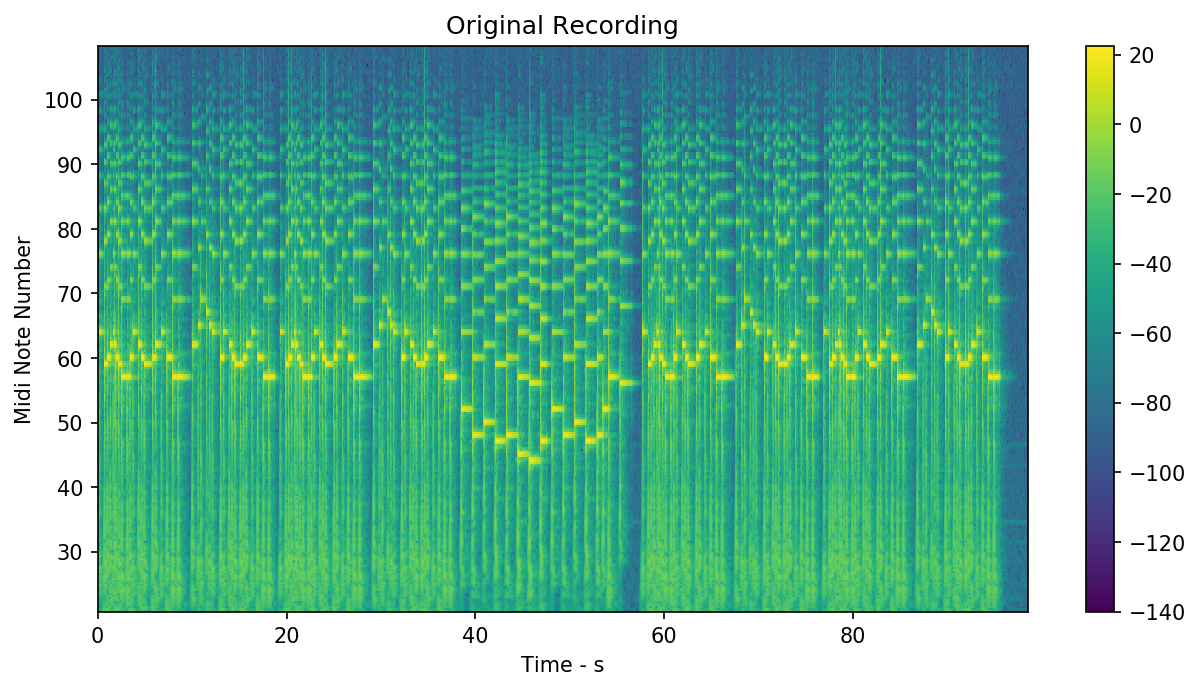

In [6]:
plt.figure(dpi = 150, figsize=(10,5))
extent=[t[0], t[-1], midi_nn[0], midi_nn[-1]]
plt.imshow(SPL, origin='lower', extent=extent, interpolation='none', aspect='auto')
plt.xlabel('Time - s')
plt.ylabel('Midi Note Number')
plt.title('Original Recording')
plt.colorbar()

#### Harmonic Component

In [7]:
CQT = lr.cqt(y=y_harmonic,bins_per_octave=bins_per_octave, fmin=fmin, n_bins=n_bins)
f = lr.cqt_frequencies(bins_per_octave=bins_per_octave, fmin=fmin, n_bins=n_bins)
midi_nn = np.arange(21-1/BANDS_PER_NOTE,108+2/BANDS_PER_NOTE, step=1/BANDS_PER_NOTE)

In [8]:
SPL = 10* np.log10( np.real(CQT * np.conj(CQT)) )

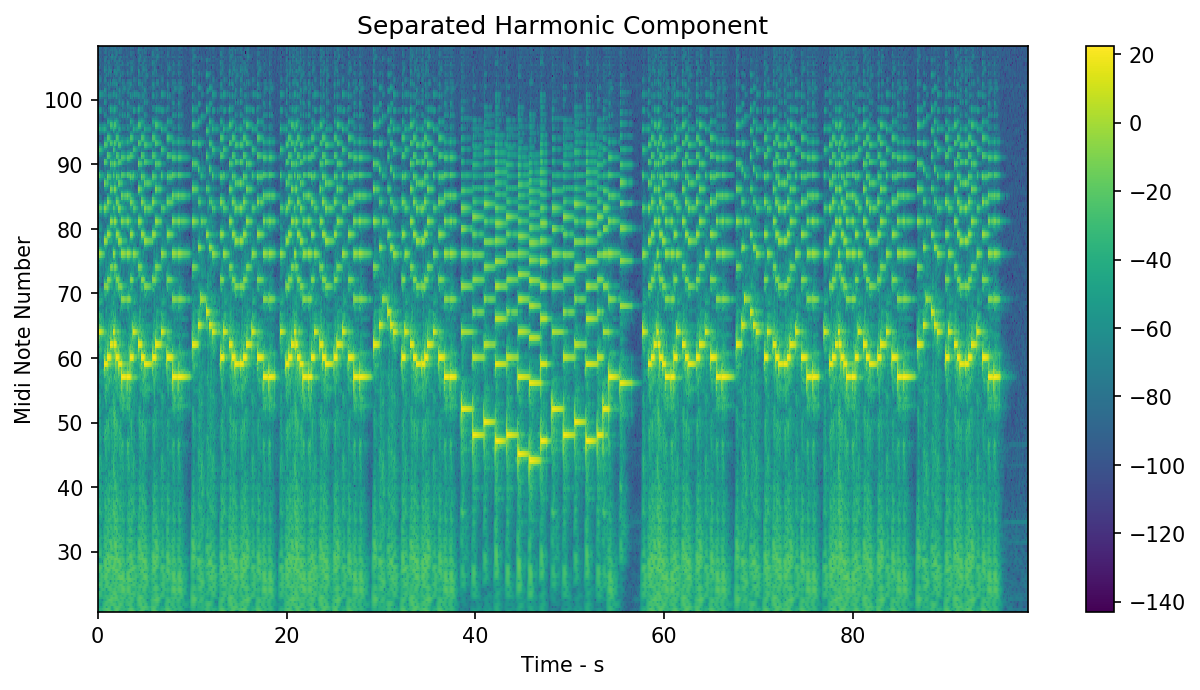

In [9]:
plt.figure(dpi = 150, figsize=(10,5))
extent=[t[0], t[-1], midi_nn[0], midi_nn[-1]]
plt.imshow(SPL, origin='lower', extent=extent, interpolation='none', aspect='auto')
plt.xlabel('Time - s')
plt.ylabel('Midi Note Number')
plt.title('Separated Harmonic Component')
plt.colorbar()

In [10]:
A_weight = np.tile(lr.A_weighting(f), [np.shape(SPL)[1],1]).T

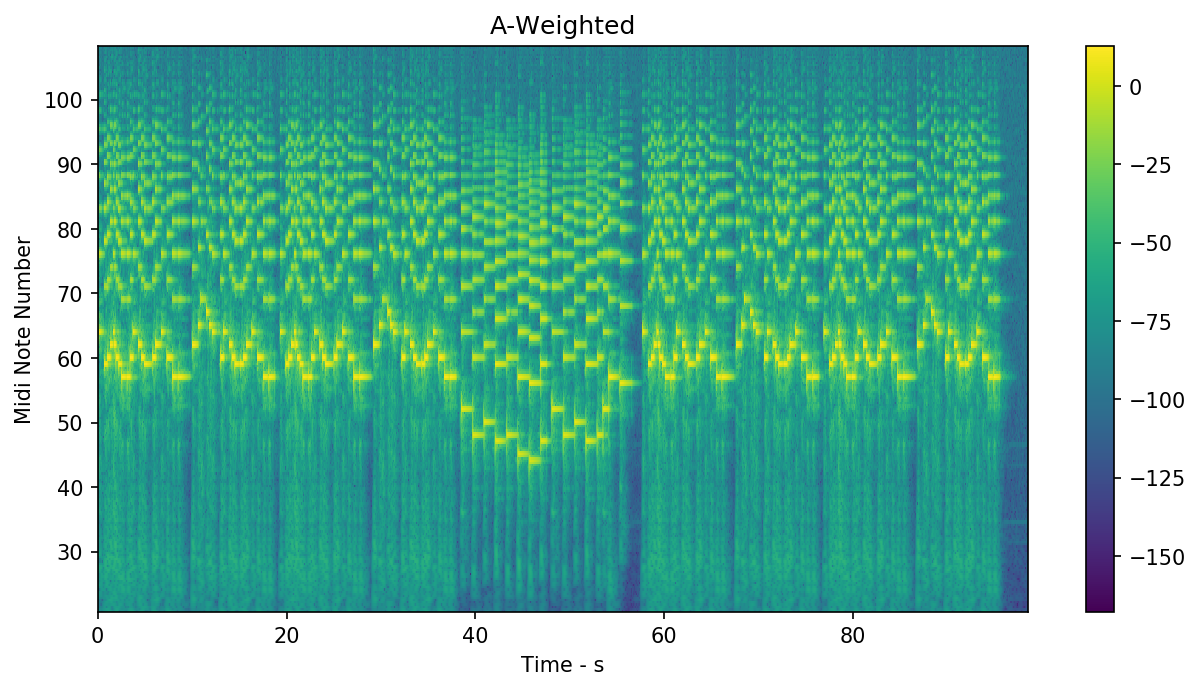

In [11]:
plt.figure(dpi = 150, figsize=(10,5))
extent=[t[0], t[-1], midi_nn[0], midi_nn[-1]]
plt.imshow(SPL+A_weight, origin='lower', extent=extent, interpolation='none', aspect='auto')
plt.xlabel('Time - s')
plt.ylabel('Midi Note Number')
plt.title('A-Weighted')
plt.colorbar()

In [12]:
def onset_impulse_response(BANDS_PER_NOTE, sigma, length):
    harmonics = np.array([0.0, 12.0, 19.0, 24.0, 28.0])
    harmonics = harmonics * BANDS_PER_NOTE
    center = np.max(harmonics)
    vert = np.zeros(int(2*center + 1))
    idx = (center + harmonics).astype('int')
    vert[idx] = 1
    penalty = np.array([0.0, 4.0, 9.0, 16.0]) * BANDS_PER_NOTE
    idx = penalty.astype('int')
    vert[idx] = -1
    window = sp.signal.gaussian(len(vert),len(vert) * 0.3)
#     vert = vert * window
    offset = np.arange(-center, center+1, 1)
    x = np.linspace(-np.pi, np.pi, length); 
#     [X,Y] = np.meshgrid(np.tanh(x), vert)
    [X,Y] = np.meshgrid(1, vert)
    midpt = int(np.shape(X)[0]/2);
    X[0:midpt,:] = 1
    H = X*Y
#     H = np.flipud(np.fliplr(X*Y))
    return H, offset

In [13]:
sigma = 0.3
length = 100
H,offset = onset_impulse_response(BANDS_PER_NOTE, sigma, length)

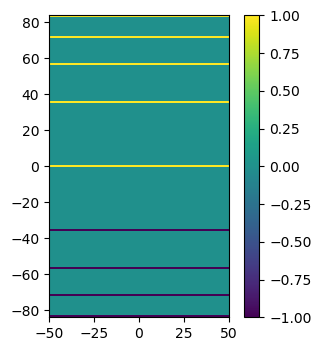

In [14]:
plt.figure(dpi = 100, figsize=(4,4))
extent=[-length/2, length/2, offset[0], offset[-1]]
plt.imshow(H,origin='lower', extent=extent)
plt.colorbar()

In [15]:
filtered = sp.ndimage.filters.correlate(SPL+A_weight, H)

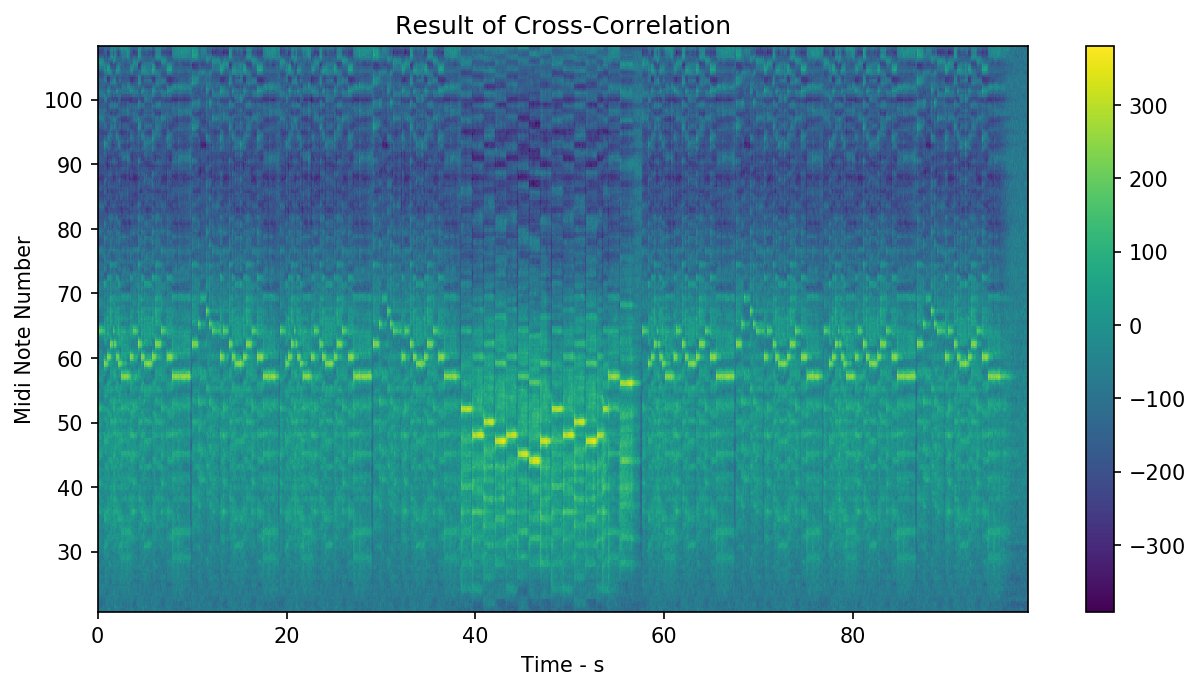

In [16]:
plt.figure(dpi = 150, figsize=(10,5))
extent=[t[0], t[-1], midi_nn[0], midi_nn[-1]]
plt.imshow(filtered, origin='lower', extent=extent, interpolation='none', aspect='auto')
plt.xlabel('Time - s')
plt.ylabel('Midi Note Number')
plt.title('Result of Cross-Correlation')
plt.colorbar()

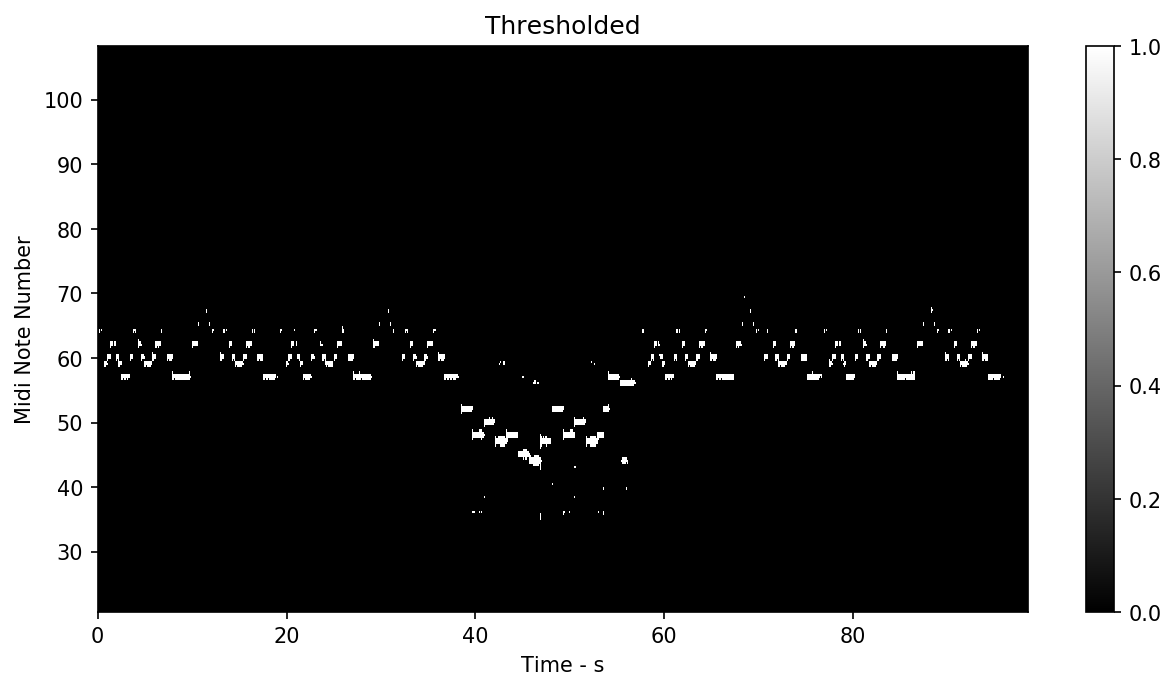

In [17]:
plt.figure(dpi = 150, figsize=(10,5))
extent=[t[0], t[-1], midi_nn[0], midi_nn[-1]]
plt.imshow(filtered>170, origin='lower', extent=extent, interpolation='none', aspect='auto',cmap='gray')
plt.xlabel('Time - s')
plt.ylabel('Midi Note Number')
plt.title('Thresholded')
plt.colorbar()

In [18]:
threshold = 170
transcription = (filtered[1:-1:3,:]>threshold).astype('int')

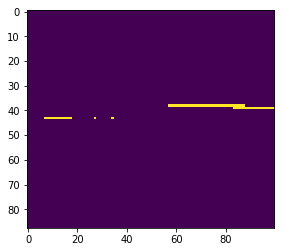

In [19]:
plt.imshow(transcription[:,0:100])

In [20]:
import midi

In [43]:
ms_per_tick = (60000 / (120 * 192))
ms_per_window = sr / 512
recon_fact = 5

In [44]:
recon_fact

5

In [45]:
onset = np.diff(transcription,1) == 1
offset = np.diff(transcription,1) == -1
onset_time, onset_note = np.where(onset.T)
offset_time, offset_note = np.where(offset.T)
note_data = np.zeros([len(onset_time),3])

In [46]:
for i_onset, note in enumerate(onset_note):
    note_data[i_onset,0] = onset_time[i_onset]*recon_fact
    note_data[i_onset,1] = onset_note[i_onset]
    i_offset = np.where(offset_note == note)[0]
    if i_offset.size == 0:
        note_data[i_onset,2] = np.shape(transcription)[1]
    else:
        i_offset = i_offset[0]
        note_data[i_onset][2] = offset_time[i_offset]*recon_fact
    offset_time = np.delete(offset_time, i_offset)
    offset_note = np.delete(offset_note, i_offset)

In [47]:
events = np.zeros([2*np.shape(note_data)[0],3])
for i_note, note in enumerate(note_data):
    events[2*i_note,0] = note_data[i_note,0]
    events[2*i_note+1,0] = note_data[i_note,2]
    events[2*i_note,1] = note_data[i_note,1]
    events[2*i_note+1,1] = note_data[i_note,1]
    events[2*i_note,2] = 0
    events[2*i_note+1,2] = 1
order = np.argsort(events[:,0])
events = events[order]

In [48]:
pattern = midi.Pattern()
track = midi.Track()
pattern.append(track)
cur_tick = 0.
for i_event, event in enumerate(events):
    #add midi event
    rel_tick = event[0] - cur_tick
    cur_tick = cur_tick + rel_tick
    
    if event[2] == 0:
        on = midi.NoteOnEvent(tick=int(rel_tick), velocity=100, pitch=int(event[1]))
        track.append(on)
    else:
        off = midi.NoteOffEvent(tick=int(rel_tick), pitch=int(event[1]))
        track.append(off)
    
eot = midi.EndOfTrackEvent(tick=1)
track.append(eot)
midi.write_midifile("example2.mid",pattern)